In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import b3d
import sys

sys.path.append(str(b3d.get_root_path()))

In [10]:
from tests.sama4d.video_to_tracks.video_to_tracks_task import VideoToTracksTask
from tests.sama4d.video_to_tracks.solvers.conv_with_reinstantiation import PatchTracker2DSolver
import genjax
import rerun

genjax.pretty()

In [4]:
rerun.init("multiple_patch_with_reinstantiation--long")
rerun.connect("127.0.0.1:8812")

In [15]:
path = b3d.get_assets_path() / 'shared_data_bucket/dynamic_SfM/feature_track_data/pan_around_blocks.npz'
ftd_og = b3d.io.FeatureTrackData.load(str(path)).slice_time(20, 80)

In [16]:
task = VideoToTracksTask.from_feature_track_data(ftd_og, has_no_moving_objects=True)
task.visualize_task()

In [17]:
solver = PatchTracker2DSolver(
    patch_size=11,
    num_tracks=80,
    frames_before_adding_to_active_set=7,
    reinitialize_patches=True,
    culling_error_threshold=60,
    culling_error_ratio_threshold=0.8,
    mindist_for_second_error=4,
    maxdist_for_second_error=40
)

In [18]:
spec = task.get_task_specification()

In [19]:
solution = solver.solve(spec)

In [ ]:
task.visualize_solution(solution, task.score(solution))

/home/georgematheos/b3d/tests/sama4d/video_to_tracks/video_to_tracks_task.py:160: UserWarning: The current scoring logic is a placeholder; it needs to be implemented.
  "The current scoring logic is a placeholder; it needs to be implemented."


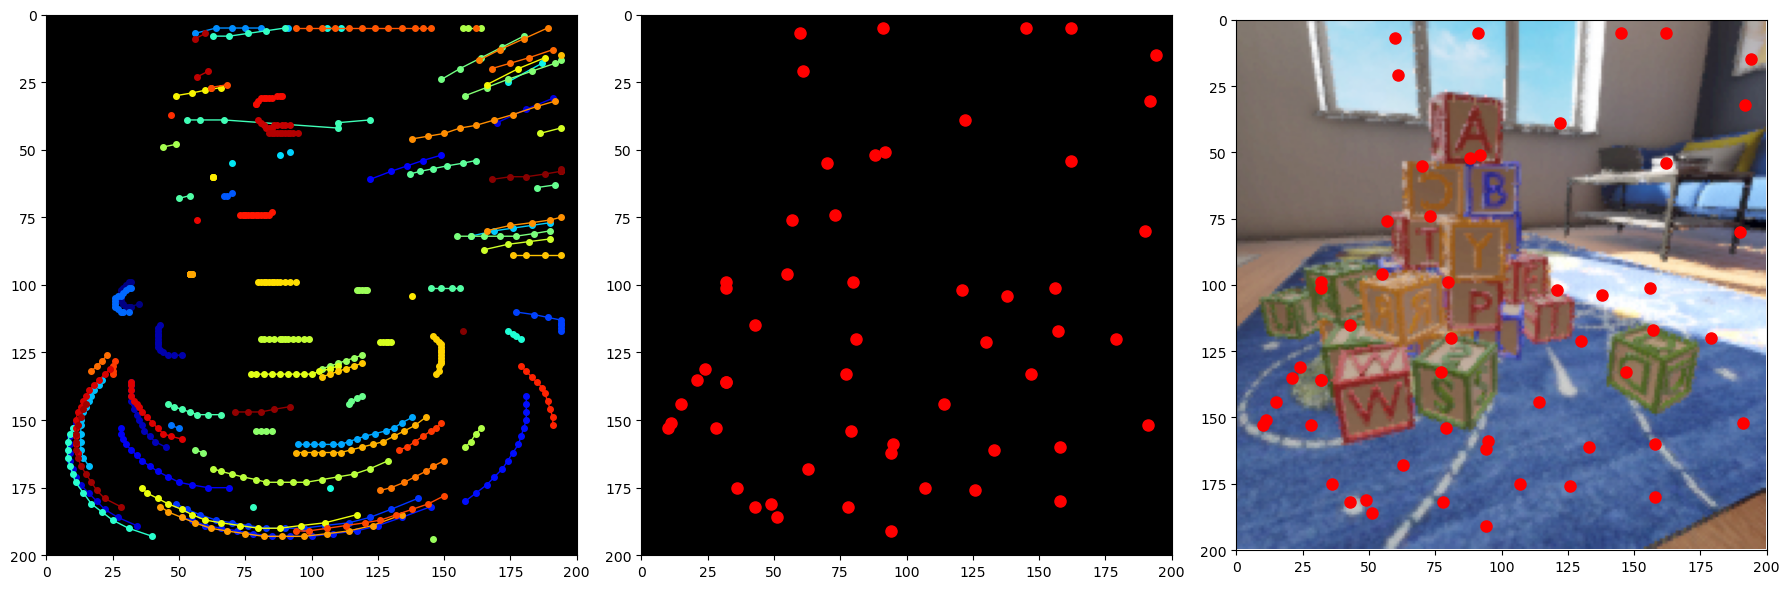

In [ ]:
task.matplotlib_visualization(solution, save_at="test.mp4")

In [ ]:
### Scratch work! ###

In [104]:
import jax.numpy as jnp

def expand_keypoint_tracks(keypoint_tracks_2d, visibility, is_new):
    T, N, _ = keypoint_tracks_2d.shape
    
    new_tracks = []
    new_visibility = []

    for n in range(N):
        changepoints = jnp.concatenate([jnp.array([0]), jnp.where(is_new[:, n])[0], jnp.array([T])])
        idx_pairs = jnp.stack([changepoints[:-1], changepoints[1:]], axis=1)
        for low, high in idx_pairs:
            # get the track with zeros everywhere but between the changepoints
            track = jnp.zeros((T, 2)).at[low:high].set(keypoint_tracks_2d[low:high, n])
            new_tracks.append(track)

            # get the visibility with zeros everywhere but between the changepoints
            vis = jnp.zeros(T, dtype=bool).at[low:high].set(visibility[low:high, n])
            new_visibility.append(vis)

    return jnp.stack(new_tracks, axis=1), jnp.stack(new_visibility, axis=1)

In [101]:
jnp.where(is_new[:, n])[0].shape

(1,)

In [99]:
T, N, _ = keypoint_tracks_2d.shape
new_tracks = []
new_visibility = []

n = 0
changepoints = jnp.concatenate([jnp.array([0]), jnp.where(is_new[:, n])[0], jnp.array([T])])
changepoints

<Array([0, 1, 5], dtype=int32)
  <Arrayviz rendering>
>

In [105]:
# Example usage
T, N = 5, 3  # T time steps, N keypoints
keypoint_tracks_2d = jnp.ones((T, N, 2))  # Example keypoint coordinates
visibility = jnp.array([[True, True, False], [True, False, True], [True, True, True], [True, True, False], [False, True, True]])
is_new = jnp.array([[False, False, False], [True, False, False], [False, False, False], [False, True, False], [False, False, False]])

keypoint_tracks_2d_new, visibility_new = expand_keypoint_tracks(keypoint_tracks_2d, visibility, is_new)

In [106]:
keypoint_tracks_2d_new[:, :, 0]

<jax.Array float32(5, 5) ≈0.6 ±0.49 [≥0.0, ≤1.0] zero:10 nonzero:15
  <Arrayviz rendering>
>

In [108]:
visibility_new

# jax.Array bool(5, 5) true:11 false:14
  Array([[ True, False,  True, False, False],
         [False,  True, False, False,  True],
         [False,  True,  True, False,  True],
         [False,  True, False,  True, False],
         [False, False, False,  True,  True]], dtype=bool)

In [98]:
is_new

# jax.Array bool(5, 3) true:2 false:13
  Array([[False, False, False],
         [ True, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False]], dtype=bool)

In [60]:
visibility_new

# jax.Array bool(5, 3) true:9 false:6
  Array([[ True,  True, False],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False, False,  True]], dtype=bool)

In [45]:
is_new

# jax.Array bool(5, 3) true:2 false:13
  Array([[False, False, False],
         [ True, False, False],
         [False, False, False],
         [False,  True, False],
         [False, False, False]], dtype=bool)